In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from torch.utils.data import DataLoader

# import spacy
import numpy as np

import random
import math
import time
from torch.utils.data import Dataset

In [2]:
class MyDataset(Dataset):

    def __init__(self, input_data, labels, input_masks):
        self.input_data = input_data
        self.labels = labels
        self.input_masks = input_masks


    def __len__(self):
        return len(self.input_data)


    def __getitem__(self, idx):
        input_item = self.input_data[idx]
        label_item = self.labels[idx]
        mask_item = self.input_masks[idx]

        return input_item, label_item, mask_item

In [3]:
def array_to_tensor(array):
    tensor = torch.from_numpy(array)
    tensor = tensor.type(torch.cuda.FloatTensor)
    return tensor

In [4]:
class Attention(nn.Module):
    
    def __init__(self, input_size, attention_size):
        
        super().__init__()
        self.attn = nn.Linear(input_size, attention_size)
        self.v = nn.Linear(attention_size, 1, bias=False)
    
    def forward(self, src, src_mask):
        
        # src = (batch, seq_len, input_size) input_size = 1
        # src_mask = (batch, seq_len)
        
        # energy = (batch, seq_len, attention_size)
        energy = torch.tanh(self.attn(src))
        
        # attention = (batch, seq_len, 1)
        # attention = (batch, seq_len)
        energy = self.v(energy).squeeze()
        
        energy = energy.masked_fill(src_mask == 0, -1e10)
     
        # (batch, seq_len)
        attention_weights = F.softmax(energy, dim=1)
        
        # (batch, seq_len, 1)
        attention_weights = attention_weights.unsqueeze(2)
       
     
        context = attention_weights * src
        # context = (batch, seq_len, input_size)
        
        # return weights
        return context, attention_weights

### 测试一下

In [5]:
# sequence_length = 3321
# half_length = sequence_length // 2
# num_masks = 10
# x_mask = [torch.cat((torch.ones(half_length), torch.zeros(sequence_length - half_length))) for _ in range(num_masks)]
# x_mask = torch.stack(x_mask)

In [6]:
# print(x_mask.shape)

In [7]:
# x = torch.randn(10, 3321, 1)
# attention_layer = Attention(1, 128)
# x, attention_weights = attention_layer(x, x_mask)

In [8]:
# print(x.shape)
# print(attention_weights.shape)
# print(attention_weights.squeeze())
# print(x[0])

In [9]:
class PositionwiseFeedforwardLayer(nn.Module):

    def __init__(self, input_dim, pf_dim, dropout):
        super().__init__()

        self.fc_1 = nn.Linear(input_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        
        # x = [batch size, seq len, input_dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        # x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        # x = [batch size, seq len, input_dim]

        return x

### 测试一下

In [10]:
# sequence_length = 3321
# half_length = sequence_length // 2
# num_masks = 10
# x_mask = [torch.cat((torch.ones(half_length), torch.zeros(sequence_length - half_length))) for _ in range(num_masks)]
# x_mask = torch.stack(x_mask)

# ######################################################
# x = torch.randn(10, 3321, 32)
# attention_layer = Attention(32, 128)
# x, attention_weights = attention_layer(x, x_mask)

# print(x.shape)
# print(attention_weights.shape)

# ######################################################
# pf_layer = PositionwiseFeedforwardLayer(32, 64, 0.1)
# x = pf_layer(x)

# print(x.shape)

In [11]:
class EncoderLayer(nn.Module):

    def __init__(self,
                 input_size,
                 pre_size,
                 attention_size,
                 pf_dim,
                 dropout):
        
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(pre_size)
        self.ff_layer_norm = nn.LayerNorm(pre_size)
        self.self_attention = Attention(pre_size, attention_size)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(pre_size,
                                                                     pf_dim,
                                                                     dropout)
        self.pre_process = nn.Linear(input_size, pre_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        # src = [batch size, src_len, input_dim]
        # src_mask = [batch size, src len]

        # src = [batch, seq len, pre_size]
        src = self.pre_process(src)
        
        # self attention
        _src, _ = self.self_attention(src, src_mask)
    
        # src = [batch, seq_len, input_dim]

        # dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        # src = [batch size, src len, hid dim]

        # positionwise feedforward
        _src = self.positionwise_feedforward(src)

        # dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))

        # src = [batch size, src len, hid dim]

        return src

### Pre-process layer

### 测试一下

In [12]:

# input_size = 1
# pre_size = 32
# attention_size = 128
# pd_dim = 64
# dropout = 0.1

# #####################################################

# # mask 

# sequence_length = 3321
# half_length = sequence_length // 2
# num_masks = 10
# x_mask = [torch.cat((torch.ones(half_length), torch.zeros(sequence_length - half_length))) for _ in range(num_masks)]
# x_mask = torch.stack(x_mask)
# print("x_mask is in shape of {} ".format(x_mask.shape))
# ######################################################

# # src

# x = torch.randn(10, 3321, input_size)

# print("x is in shape of {} ".format(x.shape))
# ######################################################

# # encoder layer

# enc_layer = EncoderLayer(input_size, pre_size, attention_size, pd_dim, dropout)
# x = enc_layer(x, x_mask)
# print(x.shape)

## Encoder

In [13]:
class Encoder(nn.Module):
    
    # 目前先用一层的encoder试试
    
    def __init__(self, 
                 n_layers,
                 input_size,
                 pre_size,
                 attention_size,
                 pf_dim,
                 dropout,
                 device_list):
        super().__init__()
        
        self.device = device_list
        
        self.layers = nn.ModuleList([EncoderLayer(input_size,
                                                  pre_size,
                                                  attention_size,
                                                  pf_dim,
                                                  dropout).to(self.device[i])
                                     for i in range(n_layers)])

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, x_mask):
        
        for number, layer in enumerate(self.layers):
            x = layer(x.to(self.device[number]), x_mask.to(self.device[number]))
        
        return x

### 测试一下

In [14]:
# input_size = 1
# pre_size = 32
# attention_size = 128
# pf_dim = 64
# dropout = 0.1
# #####################################################

# # mask 
# sequence_length = 3321
# half_length = sequence_length // 2
# num_masks = 10
# x_mask = [torch.cat((torch.ones(half_length), torch.zeros(sequence_length - half_length))) for _ in range(num_masks)]
# x_mask = torch.stack(x_mask)
# print("x_mask is in shape of {} ".format(x_mask.shape))
# ######################################################

# # src
# x = torch.randn(10, 3321, input_size)

# print("x is in shape of {} ".format(x.shape))
# ######################################################

# # Encoder

# device_list = ["cpu", "cpu", "cpu","cpu"]

# encoder = Encoder(1, input_size, pre_size, attention_size, pf_dim, dropout, device_list)
# x = encoder(x, x_mask)
# print("encoded x is in the shape of {} ".format(x.shape))

## Decoder 

decoder 需要考虑信息汇聚，这里我们可以加入一个传统的attention layer 还是通过mask避免pad token的影响

In [15]:
class Aggregation_Attention(nn.Module):
    
    def __init__(self, pre_size, attention_size):
        
        super().__init__()
        self.attn = nn.Linear(pre_size, attention_size)
        self.v = nn.Linear(attention_size, 1, bias=False)
    
    def forward(self, src, src_mask):
        
        # src = (batch, seq_len, pre_size) 
        # src_mask = (batch, seq_len)
        
        # energy = (batch, seq_len, attention_size)
        energy = torch.tanh(self.attn(src))
        
        # energy = (batch, seq_len, 1)
        energy = self.v(energy).squeeze()
        # energy = (batch, seq_len)
        
        energy = energy.masked_fill(src_mask == 0, -1e10)
     
        # (batch, seq_len)
        attention_weights = F.softmax(energy, dim=1)
        
        # (batch, 1, seq_len)
        attention_weights = attention_weights.unsqueeze(1)
       
         
        context = torch.bmm(attention_weights, src).squeeze()
        # context = (batch, pre_size)
        
        # return weights
        return context, attention_weights

### 测试一下

In [16]:
# input_size = 1
# pre_size = 32
# attention_size = 128
# pf_dim = 64
# dropout = 0.1
# #####################################################

# # mask 
# sequence_length = 3321
# half_length = sequence_length // 2
# num_masks = 10
# x_mask = [torch.cat((torch.ones(half_length), torch.zeros(sequence_length - half_length))) for _ in range(num_masks)]
# x_mask = torch.stack(x_mask)
# print("x_mask is in shape of {} ".format(x_mask.shape))
# ######################################################

# # src
# x = torch.randn(10, 3321, input_size)

# print("x is in shape of {} ".format(x.shape))
# ######################################################

# # Encoder

# device_list = ["cpu", "cpu", "cpu","cpu"]

# encoder = Encoder(1, input_size, pre_size, attention_size, pf_dim, dropout, device_list)
# x = encoder(x, x_mask)
# print("encoded x is in the shape of {} ".format(x.shape))


# ###########################################################

# # decoder aggregation attention layer

# ag_attn_layer = Aggregation_Attention(pre_size, attention_size)
# x, _ = ag_attn_layer(x, x_mask)
# print(x.shape)

In [17]:
class DecoderLayer(nn.Module):

    def __init__(self, 
                 pre_size, 
                 attention_size
                ):
        
        super().__init__()

        self.ag_attn_layer = Aggregation_Attention(pre_size, attention_size)
        
        self.fc1 = nn.Linear(in_features=pre_size, out_features=196)
        nn.init.xavier_normal_(self.fc1.weight)
        
        self.fc2 = nn.Linear(in_features=196, out_features=774)
        nn.init.xavier_normal_(self.fc2.weight)
        
        self.fc3 = nn.Linear(in_features=774, out_features=211)
        nn.init.xavier_normal_(self.fc3.weight)
        
        self.fc4 = nn.Linear(in_features=211, out_features=6)
        nn.init.xavier_normal_(self.fc4.weight)
        
    def forward(self, x, x_mask):
        
        # x = [batch, seq_len, pre_size]
        # x_mask = [batch, seq_len]
        x, _ = self.ag_attn_layer(x, x_mask)
        
        x = self.fc1(x)
        # x = self.bn1(x)
        x = torch.sigmoid(x)
        
        x = self.fc2(x)
        # x = self.bn2(x)
        x = torch.sigmoid(x)
        # x = self.dropout1(x)
        
        x = self.fc3(x)
        x = torch.sigmoid(x)
        
        x = self.fc4(x)
        x = torch.sigmoid(x)
        
        return x

###  测试一下

In [18]:
# input_size = 1
# pre_size = 32
# attention_size = 128
# pf_dim = 64
# dropout = 0.1
# #####################################################

# # mask 
# sequence_length = 3321
# half_length = sequence_length // 2
# num_masks = 10
# x_mask = [torch.cat((torch.ones(half_length), torch.zeros(sequence_length - half_length))) for _ in range(num_masks)]
# x_mask = torch.stack(x_mask)
# print("x_mask is in shape of {} ".format(x_mask.shape))
# ######################################################

# # src
# x = torch.randn(10, 3321, input_size)

# print("x is in shape of {} ".format(x.shape))
# ######################################################

# # Encoder

# device_list = ["cpu", "cpu", "cpu","cpu"]

# encoder = Encoder(1, input_size, pre_size, attention_size, pf_dim, dropout, device_list)
# x = encoder(x, x_mask)
# print("encoded x is in the shape of {} ".format(x.shape))


# ###########################################################

# # Decoder layer

# dec_layer = DecoderLayer(pre_size, attention_size)
# x = dec_layer(x, x_mask)
# print(x.shape)

In [19]:
class Decoder(nn.Module):

    def __init__(self, 
                 pre_size, 
                 attention_size,
                 device_list
                ):
        
        super().__init__()
        
        
        self.device = device_list
        
        self.layers = DecoderLayer(pre_size, attention_size)

    def forward(self, x, x_mask):
        
        x = self.layers(x.to(self.device), x_mask.to(self.device))
        
        return x

### 测试一下

In [20]:
# input_size = 1
# pre_size = 32
# attention_size = 128
# pf_dim = 64
# dropout = 0.1
# #####################################################

# # mask 
# sequence_length = 3321
# half_length = sequence_length // 2
# num_masks = 10
# x_mask = [torch.cat((torch.ones(half_length), torch.zeros(sequence_length - half_length))) for _ in range(num_masks)]
# x_mask = torch.stack(x_mask)
# print("x_mask is in shape of {} ".format(x_mask.shape))
# ######################################################

# # src
# x = torch.randn(10, 3321, input_size)

# print("x is in shape of {} ".format(x.shape))
# ######################################################

# # Encoder

# device_list = ["cpu", "cpu", "cpu","cpu"]

# encoder = Encoder(1, input_size, pre_size, attention_size, pf_dim, dropout, device_list)
# x = encoder(x, x_mask)
# print("encoded x is in the shape of {} ".format(x.shape))


# ###########################################################

# # Decoder
# device_list = ["cpu"]

# dec_layer = Decoder(pre_size, attention_size, device_list[0])
# x = dec_layer(x, x_mask)

# print(x.shape)

# The whole Model

In [21]:
class Spec_transformer(nn.Module):
    
    def __init__(self, Encoder, Decoder):
        
        super().__init__()
        
        self.encoder = Encoder
        self.decoder = Decoder
        
    def forward(self, x, x_mask):
        
        x = self.encoder(x, x_mask)
        out = self.decoder(x, x_mask)
        
        return out

### 测试一下

In [22]:
# input_size = 1
# pre_size = 32
# attention_size = 128
# pf_dim = 64
# dropout = 0.1
# device_list = ["cpu", "cpu", "cpu","cpu"]
# #####################################################

# # mask 
# sequence_length = 3321
# half_length = sequence_length // 2
# num_masks = 10
# x_mask = [torch.cat((torch.ones(half_length), torch.zeros(sequence_length - half_length))) for _ in range(num_masks)]
# x_mask = torch.stack(x_mask)
# print("x_mask is in shape of {} ".format(x_mask.shape))
# ######################################################

# # src
# x = torch.randn(10, 3321, input_size)

# print("x is in shape of {} ".format(x.shape))
# ######################################################

# encoder = Encoder(1, input_size, pre_size, attention_size, pf_dim, dropout, device_list)
# decoder = Decoder(pre_size, attention_size, device_list[0])

# spectrans = Spec_transformer(encoder, decoder)

# pred = spectrans(x, x_mask)
# print(pred.shape)

### Train

In [23]:
input_size = 1
pre_size = 32
attention_size = 128
pf_dim = 64
dropout = 0.1
device_list = ["cpu", "cpu", "cpu","cpu"]

In [24]:
root_path = r"D:\PYHTON\python3.7\DeepLearningProgram\科研项目\Detection_of_lees_gases_in_Luzhou_Laojiao\Datasets\三组分气体生成的数据集\模拟数据集"

save_path1 = root_path + r"\padded_dataset.npy"
spectraset = np.load(save_path1)
spectraset = spectraset[:, :, np.newaxis]

save_path2 = root_path + r"\masked_dataset_label.npy"
label = np.load(save_path2)

mask_path = root_path + r"\mask.npy"
maskset = np.load(mask_path)

In [25]:
spectraset = array_to_tensor(spectraset)
maskset = array_to_tensor(maskset)
label = array_to_tensor(label)

In [26]:
print(spectraset.shape)
print(maskset.shape)
print(label.shape)

torch.Size([101500, 3321, 1])
torch.Size([101500, 3321])
torch.Size([101500, 6])


In [27]:
batch_size = 128
epoch = 3000

In [28]:
dataset = MyDataset(spectraset, label, maskset)
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [29]:
encoder = Encoder(1, input_size, pre_size, attention_size, pf_dim, dropout, ["cuda"])
decoder = Decoder(pre_size, attention_size, torch.device("cuda"))
spectrans = Spec_transformer(encoder, decoder)

In [30]:
def if_use_cuda(decision, spectrans):
    if decision:
        Gpu = torch.device("cuda")
        spectrans = spectrans.to(Gpu)
        print("nid:{} is_cuda: {}".format(id(spectrans), next(spectrans.parameters()).is_cuda))
    else:
        spectrans = spectrans.to("cpu")
        print("using cpu")

In [31]:
if_use_cuda(True, spectrans)

nid:1538794277640 is_cuda: True


In [32]:
criterion1 = nn.BCEWithLogitsLoss()
criterion2 = nn.MSELoss()
optimizer = torch.optim.Adam(spectrans.parameters(), lr=0.0001)

In [33]:
loss_list = []
classfication_loss = []
regression_loss = []
device = torch.device("cuda")

spectrans.train()
for e in range(epoch):
    
    for _, (batch_x, batch_y, batch_x_mask) in enumerate(dataloader):
        
        spectrans = spectrans.to(device)
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        batch_x_mask = batch_x_mask.to(device)
        
        
        optimizer.zero_grad()
        
        prediction = spectrans(batch_x, batch_x_mask)
        
        loss1 = criterion1(prediction[:, :3], batch_y[:, :3])
        loss2 = criterion2(prediction[:, 3:], batch_y[:, 3:])
        
        loss = loss1 + loss2
        
        loss_list.append(float(loss))
        
        loss.backward()
        optimizer.step()
        
    print(r"epoch [{}/{}] \t current loss: {:.4f}".format(e, epoch, loss.item()))

epoch [0/3000] \t current loss: 0.6092
epoch [1/3000] \t current loss: 0.6015
epoch [2/3000] \t current loss: 0.5643
epoch [3/3000] \t current loss: 0.5798
epoch [4/3000] \t current loss: 0.5275
epoch [5/3000] \t current loss: 0.5244
epoch [6/3000] \t current loss: 0.5228
epoch [7/3000] \t current loss: 0.5291
epoch [8/3000] \t current loss: 0.5453
epoch [9/3000] \t current loss: 0.5108
epoch [10/3000] \t current loss: 0.5105
epoch [11/3000] \t current loss: 0.5126
epoch [12/3000] \t current loss: 0.5269
epoch [13/3000] \t current loss: 0.5180
epoch [14/3000] \t current loss: 0.4995
epoch [15/3000] \t current loss: 0.5055
epoch [16/3000] \t current loss: 0.5113
epoch [17/3000] \t current loss: 0.5008
epoch [18/3000] \t current loss: 0.4783
epoch [19/3000] \t current loss: 0.5330
epoch [20/3000] \t current loss: 0.5178
epoch [21/3000] \t current loss: 0.4941
epoch [22/3000] \t current loss: 0.4929
epoch [23/3000] \t current loss: 0.4990
epoch [24/3000] \t current loss: 0.5211
epoch [25/

第一次试验的结果

(2379000,)
(3000,)


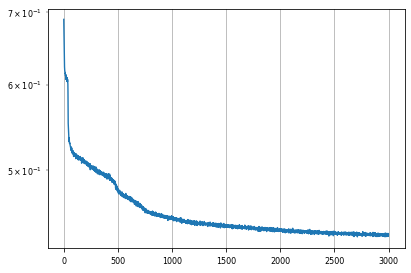

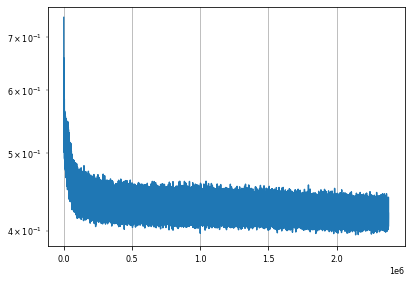

In [55]:
loss_list = np.array(loss_list)
print(loss_list.shape)
Loss = []

for i in range(epoch):
    Loss.append(np.mean(loss_list[i*80: (i+1)*80]))
Loss = np.array(Loss)
print(Loss.shape)

plt.figure()
plt.style.use('seaborn-paper')
plt.grid()
plt.yscale("log")
plt.plot(Loss)
plt.show()


plt.figure()
plt.style.use('seaborn-paper')
plt.grid()
plt.yscale("log")
plt.plot(loss_list)
plt.show()

In [46]:
path = r"D:\PYHTON\python3.7\DeepLearningProgram\科研项目\Detection_of_lees_gases_in_Luzhou_Laojiao\models\saved_model\saved_1_loss_log.npy"
np.save(path, loss_list)

In [36]:
path = r"D:\PYHTON\python3.7\DeepLearningProgram\科研项目\Detection_of_lees_gases_in_Luzhou_Laojiao\models\saved_model\saved_1.pt"
torch.save(spectrans.state_dict(), path)

# 测试结果可视化

In [37]:
def predict(logits, labs):
    components = ["甲烷", "丙酮", "水"]
    prediction = [0 if pred < 0.5 else 1 for pred in logits[:3]]
    for i in range(3):
        if prediction[i] == 0:
            components[i] = ""
            logits[i+3] = 0
    print("================================================")
    print("预测结果为：{} \n".format(prediction))
    print("混合光谱包含的成分为：{} {} {} \n".format(components[0], components[1], components[2]))
    print("对应浓度分别为：{:.2f} ppm, {:.2f} ppm, {:.2f} ppm".format(logits[3]*50, logits[4]*50, logits[5]*2000))
    print("================================================")
    
    components = ["甲烷", "丙酮", "水"]
    prediction = [0 if pred < 0.5 else 1 for pred in labs[:3]]
    for i in range(3):
        if prediction[i] == 0:
            components[i] = ""
            labs[i+3] = 0
    print("================================================")
    print("实际结果为：{} \n".format(prediction))
    print("混合光谱包含的成分为：{} {} {} \n".format(components[0], components[1], components[2]))
    print("对应浓度分别为：{:.2f} ppm, {:.2f} ppm, {:.2f} ppm".format(labs[3]*50, labs[4]*50, labs[5]*2000))
    print("================================================")

In [66]:
index = 14000
sample_spec = spectraset[index].unsqueeze(0).to(device)
print(sample_spec.shape)
sample_label = label[index]
print(sample_label.shape)
sample_mask = maskset[index].unsqueeze(0).to(device)
print(sample_mask.shape)

pred = spectrans(sample_spec, sample_mask)
y_sample = pred.cpu().detach().numpy()
print(y_sample.shape)

torch.Size([1, 3321, 1])
torch.Size([6])
torch.Size([1, 3321])
(6,)


In [67]:
predict(y_sample, sample_label)

预测结果为：[1, 1, 0] 

混合光谱包含的成分为：甲烷 丙酮  

对应浓度分别为：27.28 ppm, 1.13 ppm, 0.00 ppm
实际结果为：[1, 1, 0] 

混合光谱包含的成分为：甲烷 丙酮  

对应浓度分别为：28.00 ppm, 1.00 ppm, 0.00 ppm


继续训练

In [68]:
loss_list = []
classfication_loss = []
regression_loss = []
device = torch.device("cuda")

spectrans.train()
for e in range(1000):
    
    for _, (batch_x, batch_y, batch_x_mask) in enumerate(dataloader):
        
        spectrans = spectrans.to(device)
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        batch_x_mask = batch_x_mask.to(device)
        
        
        optimizer.zero_grad()
        
        prediction = spectrans(batch_x, batch_x_mask)
        
        loss1 = criterion1(prediction[:, :3], batch_y[:, :3])
        loss2 = criterion2(prediction[:, 3:], batch_y[:, 3:])
        
        loss = loss1 + loss2
        
        loss_list.append(float(loss))
        
        loss.backward()
        optimizer.step()
        
    print(r"epoch [{}/{}] \t current loss: {:.4f}".format(e, epoch, loss.item()))

epoch [0/3000] \t current loss: 0.4160
epoch [1/3000] \t current loss: 0.4187
epoch [2/3000] \t current loss: 0.4197
epoch [3/3000] \t current loss: 0.4199
epoch [4/3000] \t current loss: 0.4189
epoch [5/3000] \t current loss: 0.4140
epoch [6/3000] \t current loss: 0.4154
epoch [7/3000] \t current loss: 0.4253
epoch [8/3000] \t current loss: 0.4141
epoch [9/3000] \t current loss: 0.4276
epoch [10/3000] \t current loss: 0.4261
epoch [11/3000] \t current loss: 0.4219
epoch [12/3000] \t current loss: 0.4270
epoch [13/3000] \t current loss: 0.4254
epoch [14/3000] \t current loss: 0.4306
epoch [15/3000] \t current loss: 0.4097
epoch [16/3000] \t current loss: 0.4274
epoch [17/3000] \t current loss: 0.4180
epoch [18/3000] \t current loss: 0.4195
epoch [19/3000] \t current loss: 0.4196
epoch [20/3000] \t current loss: 0.4258
epoch [21/3000] \t current loss: 0.4286
epoch [22/3000] \t current loss: 0.4215
epoch [23/3000] \t current loss: 0.4259
epoch [24/3000] \t current loss: 0.4138
epoch [25/

(793000,)
(3000,)


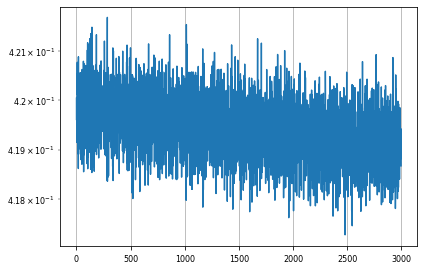

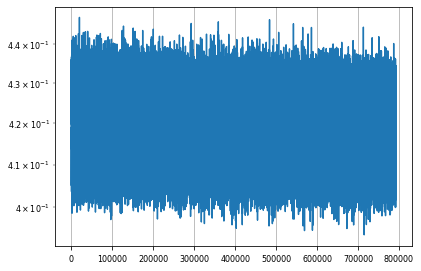

In [69]:
loss_list = np.array(loss_list)
print(loss_list.shape)
Loss = []

for i in range(epoch):
    Loss.append(np.mean(loss_list[i*80: (i+1)*80]))
Loss = np.array(Loss)
print(Loss.shape)

plt.figure()
plt.style.use('seaborn-paper')
plt.grid()
plt.yscale("log")
plt.plot(Loss)
plt.show()


plt.figure()
plt.style.use('seaborn-paper')
plt.grid()
plt.yscale("log")
plt.plot(loss_list)
plt.show()

In [70]:
path = r"D:\PYHTON\python3.7\DeepLearningProgram\科研项目\Detection_of_lees_gases_in_Luzhou_Laojiao\models\saved_model\saved_2_loss_log.npy"
np.save(path, loss_list)

path = r"D:\PYHTON\python3.7\DeepLearningProgram\科研项目\Detection_of_lees_gases_in_Luzhou_Laojiao\models\saved_model\saved_2.pt"
torch.save(spectrans.state_dict(), path)

In [74]:
index = 19000
sample_spec = spectraset[index].unsqueeze(0).to(device)
print(sample_spec.shape)
sample_label = label[index]
print(sample_label.shape)
sample_mask = maskset[index].unsqueeze(0).to(device)
print(sample_mask.shape)

pred = spectrans(sample_spec, sample_mask)
y_sample = pred.cpu().detach().numpy()
print(y_sample.shape)

predict(y_sample, sample_label)

torch.Size([1, 3321, 1])
torch.Size([6])
torch.Size([1, 3321])
(6,)
预测结果为：[1, 0, 1] 

混合光谱包含的成分为：甲烷  水 

对应浓度分别为：26.83 ppm, 0.00 ppm, 1506.95 ppm
实际结果为：[1, 0, 1] 

混合光谱包含的成分为：甲烷  水 

对应浓度分别为：28.00 ppm, 0.00 ppm, 1245.00 ppm


In [72]:
predict(y_sample, sample_label)

预测结果为：[1, 1, 0] 

混合光谱包含的成分为：甲烷 丙酮  

对应浓度分别为：29.35 ppm, 1.19 ppm, 0.00 ppm
实际结果为：[1, 1, 0] 

混合光谱包含的成分为：甲烷 丙酮  

对应浓度分别为：28.00 ppm, 1.00 ppm, 0.00 ppm


In [ ]:
### 初始化模型权重

def initialize_weights(model, init_func):
    for module in model.modules():
        if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
            init_func(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)

# 选择具体的初始化函数

def custom_init_func(tensor):
    nn.init.xavier_uniform_(tensor)

# 对整个模型应用初始化方法

initialize_weights(model, custom_init_func)